# Preprocessing of CM2.6 input for air-sea flux calculation


In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [3]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, smooth_inputs_dataset
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26

In [4]:
fs = gcsfs.GCSFileSystem()

version = 'v0.5'
# suffix = '_test'
suffix = ''
# set up save targets
bucket = 'gs://leap-persistent/jbusecke' # equivalent to os.environ['PERSISTENT_BUCKET'], but this should work for all collaborators
output_path = f"{bucket}/scale-aware-air-sea/smoothed/CM26_smoothed_{version}{suffix}.zarr"
output_mapper = fs.get_mapper(output_path)

In [3]:
output_mapper.root

'leap-persistent/jbusecke/scale-aware-air-sea/smoothed/CM26_smoothed_v0.5.zarr'

In [4]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Smooth input fields

In [5]:
filter_scale = 50

smooth_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp', 'u_ocean', 'v_ocean', 'u_ref', 'v_ref']

# smooth the whole dataset with the new method
ds_merged_smoothed = smooth_inputs_dataset(ds_merged[smooth_vars], ['yt_ocean', 'xt_ocean'], filter_scale)

# add the smoothed variables to the original dataset
for var in smooth_vars:
    ds_merged[var+'_smoothed'] = ds_merged_smoothed[var]
    
# also rebuild a second relative wind from only ocean smoothed velocities
ds_merged['u_relative_smoothed_ocean_only'] = ds_merged['u_ref'] - ds_merged['u_ocean_smoothed']
ds_merged['v_relative_smoothed_ocean_only'] = ds_merged['v_ref'] - ds_merged['v_ocean_smoothed']

ds_merged['u_relative_smoothed_atmos_only'] = ds_merged['u_ref_smoothed'] - ds_merged['u_ocean']
ds_merged['v_relative_smoothed_atmos_only'] = ds_merged['v_ref_smoothed'] - ds_merged['v_ocean']

ds_merged

<xarray.Dataset>
Dimensions:                         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/25)
    slp                             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind                            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                              ...
    u_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Some sanity checks with the data before large batch save

### Check that the nanmask is uniform across variables
See https://github.com/ocean-transport/scale-aware-air-sea/issues/46



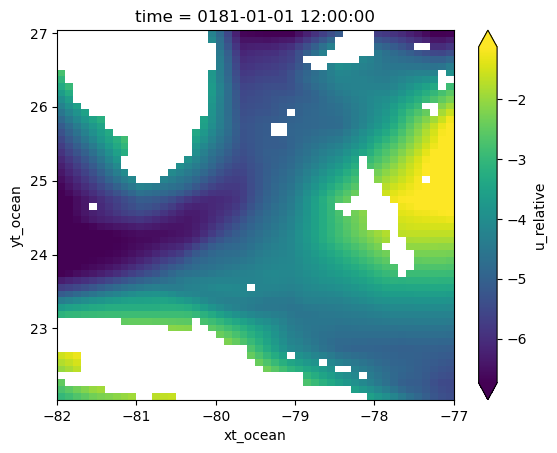

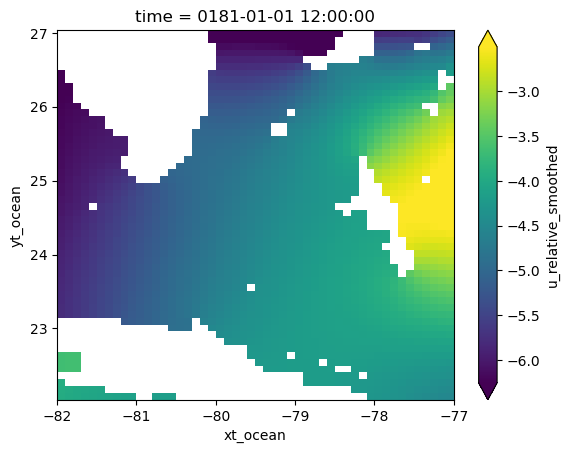

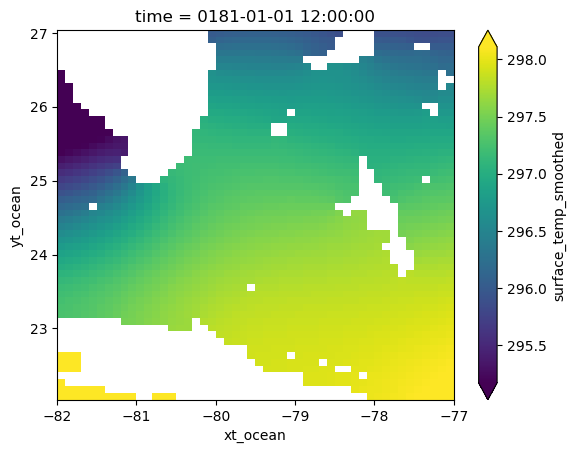

In [6]:
roi = dict(xt_ocean=slice(-82, -77), yt_ocean=slice(22,27))

plt.figure()
ds_merged['u_relative'].isel(time=0).sel(**roi).plot(robust=True)

plt.figure()
ds_merged['u_relative_smoothed'].isel(time=0).sel(**roi).plot(robust=True)

plt.figure()
ds_merged['surface_temp_smoothed'].isel(time=0).sel(**roi).plot(robust=True)

In [7]:
# prune dataset for saving
keep_vars = [
    'slp_smoothed', 'surface_temp_smoothed',
    'u_relative_smoothed','v_relative_smoothed',
    'u_relative_smoothed_ocean_only','v_relative_smoothed_ocean_only',
    'u_relative_smoothed_atmos_only','v_relative_smoothed_atmos_only',
    't_ref_smoothed', 'q_ref_smoothed'
]
# keep_vars = ['surface_temp_smoothed']
ds_save = ds_merged[keep_vars]

if suffix == '_test':
    ds_save = ds_save.isel(time=slice(0,100))
ds_save

<xarray.Dataset>
Dimensions:                         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [8]:
ds_save.nbytes/1e12

2.84018410884

## Set up a legit dask cluster

In [9]:
# distributed does not like these long tasks (>40s) we produce. 
# Lets see if we can tune that (!YES!):
import dask
dask.config.set(
    {
        "distributed.comm.timeouts.tcp": "360s",
        "distributed.comm.timeouts.connect": "360s",
    }
)

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options.worker_memory = 50 # Could proabably reduce this to something like 40, but I think that doesnt actually free up space...
options.worker_cores = 12 # could probably handle 12 here...

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.adapt(10,200)
# cluster.scale(30)
client

[ClusterReport<name=prod.5dd97fc738a944899ca4deff685de694, status=RUNNING>]


/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:1309: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+---------+
| Package | Client         | Scheduler      | Workers |
+---------+----------------+----------------+---------+
| python  | 3.9.15.final.0 | 3.9.13.final.0 | None    |
+---------+----------------+----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.744972b77c034d9384a462e912eea834/status,


In [ ]:
# But it doesnt so lets see how this fares:
to_zarr_split(ds_save, output_mapper, split_interval=1000) #formerly 1000 split

2022-12-15 03:48:10,832 - distributed.client - WARNING - Couldn't gather 17 keys, rescheduling {"('store-map-a0e3fbcf356d26d32c7237e78eb0814d', 8, 0, 0)": (), "('store-map-a0e3fbcf356d26d32c7237e78eb0814d', 116, 0, 0)": (), "('store-map-a0e3fbcf356d26d32c7237e78eb0814d', 267, 0, 0)": (), "('store-map-da6186483d6133d854561174ddc07bc7', 152, 0, 0)": (), "('store-map-eaa5563bbd01ace291417475a6c42ba8', 224, 0, 0)": (), "('store-map-c53fb45626115ea171260c7a9a1e4463', 213, 0, 0)": (), "('store-map-7915d1e47810ae87d6fc20da4f3e7b22', 3, 0, 0)": (), "('store-map-da6186483d6133d854561174ddc07bc7', 200, 0, 0)": (), "('store-map-614dc77fa7f4e9f47345f06745ac96f5', 209, 0, 0)": (), "('store-map-a0e3fbcf356d26d32c7237e78eb0814d', 206, 0, 0)": (), "('store-map-7915d1e47810ae87d6fc20da4f3e7b22', 208, 0, 0)": (), "('store-map-c53fb45626115ea171260c7a9a1e4463', 203, 0, 0)": (), "('store-map-56b635fb5c29a40d8e8e28e636d5a0c3', 197, 0, 0)": (), "('store-map-a0e3fbcf356d26d32c7237e78eb0814d', 281, 0, 0)": ()

  0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
ds = xr.open_dataset(output_mapper, engine='zarr', chunks={}, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [6]:
print(output_mapper.root)

leap-persistent/jbusecke/scale-aware-air-sea/smoothed/CM26_smoothed_v0.5.zarr


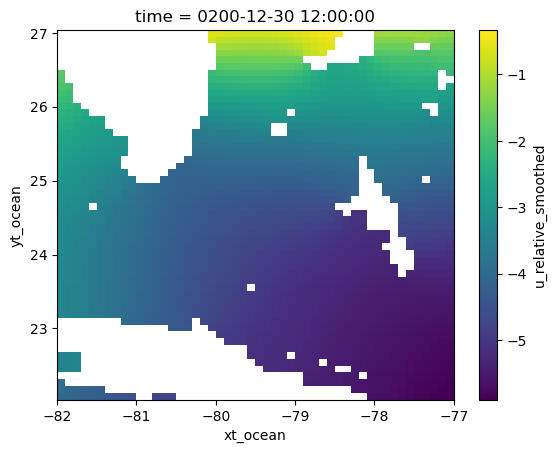

In [10]:
roi = dict(xt_ocean=slice(-82, -77), yt_ocean=slice(22,27))
ds.isel(time=-2)['u_relative_smoothed'].sel(**roi).plot()